In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
warnings.filterwarnings("ignore")

##  I. Goal

The notebook demonstrates examples for implementing models by instructing it how to arrive at the output 

## II. Usecase 1: The model prediction must be a decreasing (or increasing) function of x1

An example for implementing this usecase is the Boston Housing toy dataset imported from sklearn datasets. It has 506 rows and 13 attributes.To implement use case 1 we will create two XGBoost models one with no directional constraints and the second with a directional constraints on the RM, CRIM, NOX, DIS, PTRATIO and LSTAT attributes.

In [3]:
boston_dataset = load_boston()
print(boston_dataset.keys())

dict_keys(['target', 'DESCR', 'data', 'feature_names'])


Boston Housing dataset description:

In [4]:
print(boston_dataset.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [5]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.drop(columns=['B'], inplace=True)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33


In [6]:
boston['MEDV'] = boston_dataset.target

In [7]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
MEDV       0
dtype: int64

In [8]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


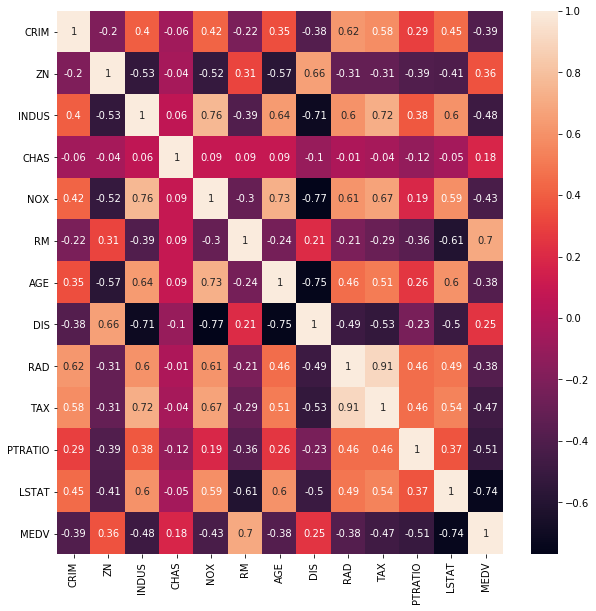

In [9]:
correlation_matrix = boston.corr().round(2)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(data=correlation_matrix, annot=True, ax=ax)

Figure 1: Correlation Matrix of Boston Housing dataset

In [10]:
# Read data and split into train test sets 
X, y = boston.iloc[:,:-1], boston.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [11]:
def print_results(result):
     
    """
    The function takes in a fitted model and prints the best params and training and test set performance 
    """
    
    print("XGB Model best params : {}".format(result.best_params_))
    
    ypred_train = result.predict(X_train)
    mse_train = mean_squared_error(y_train, ypred_train)
    print(" Train RMSE: %.5f" % (mse_train**(1/2.0)))
    
    ypred_test = result.predict(X_test)
    mse_test = mean_squared_error(y_test, ypred_test)
    print(" Test RMSE: %.5f" % (mse_test**(1/2.0)))

### XGB Model with no directional constraints

In [12]:
param_grid = {
                'max_depth':range(2,7), 
                'learning_rate': [.07,.09, .1, .2], 
                'random_state': [123],
                'objective':['reg:squarederror'], 
                'n_estimators': [150, 170, 200, 250, 300],
                'reg_gamma': [0, 0.2, 0.5]
}

xgbr = xgb.XGBRegressor()
gr = GridSearchCV(xgbr,param_grid=param_grid,cv=5, verbose=True)
res = gr.fit(X_train,y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  3.5min finished


In [13]:
print_results(res)

XGB Model best params : {'reg_gamma': 0, 'learning_rate': 0.07, 'random_state': 123, 'objective': 'reg:squarederror', 'max_depth': 6, 'n_estimators': 170}
 Train RMSE: 0.30307
 Test RMSE: 2.80489


Text(0.5, 0, 'Relative Importance')

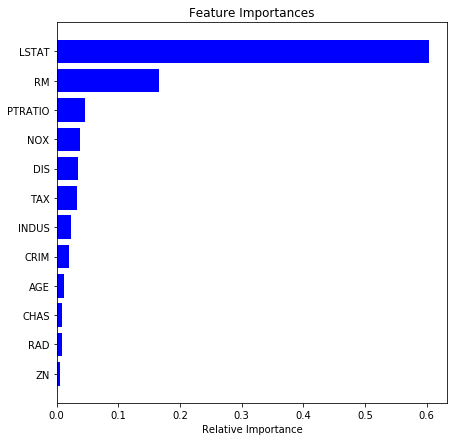

In [14]:
features = X_train.columns
importances = res.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

In [15]:
def get_partial_dependence(res, feature, X, y):
    data = X.copy()
    grid = np.linspace(np.percentile(data.loc[:, feature], 0.1),
                       np.percentile(data.loc[:, feature], 99.5),
                    50)
    y_pred = np.zeros(50)
    for i, val in enumerate(grid):
                data.loc[:, feature] = val
                pred = res.predict(data)
                y_pred[i] = np.average(pred)
    
    return grid, y_pred

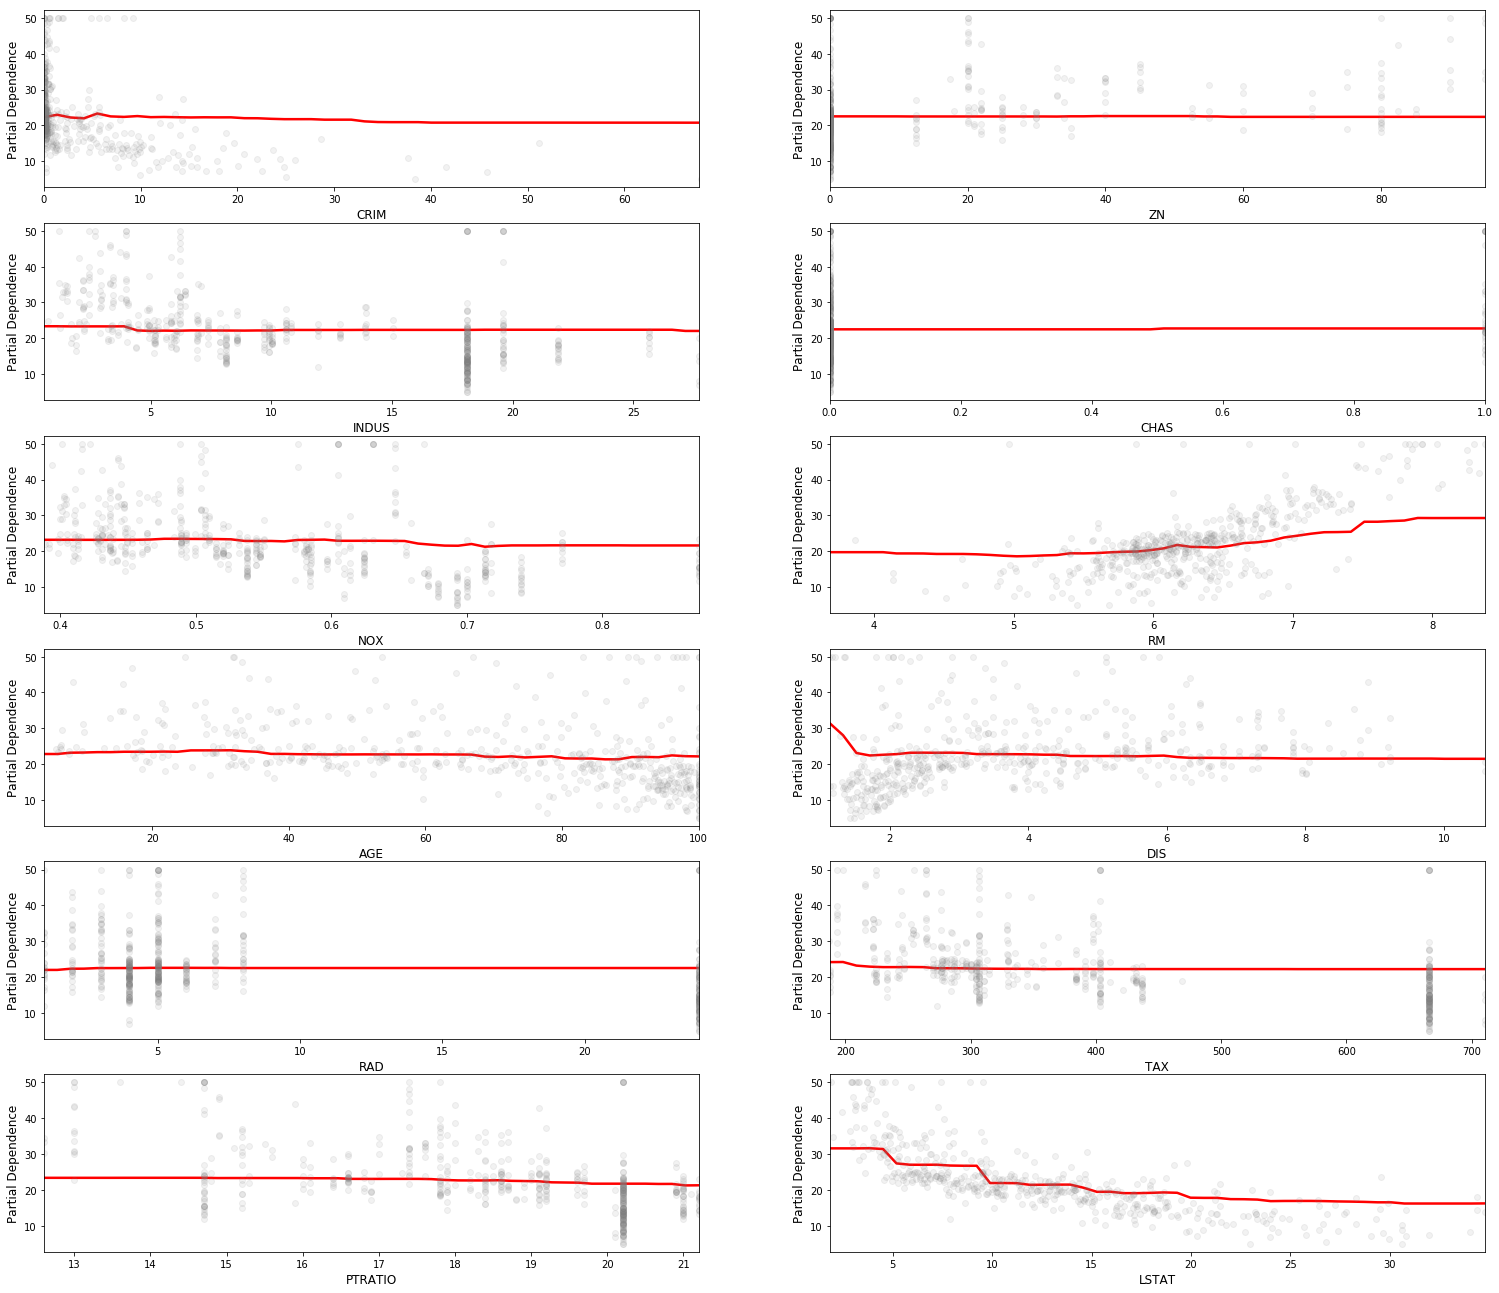

In [16]:
features = X_train.columns
fig, ax = plt.subplots(6, 2)
fig.set_size_inches(23, 23)
plt.subplots_adjust(left = 0.07, right = 0.94, bottom = 0.15, top = 0.9)
for i, f in enumerate(features):
    grid, y_pred = get_partial_dependence(res, f, X_train, y_train)
    ax = ax.flatten()
    axis = ax[i]
    axis.plot(grid, y_pred, color = 'red', linewidth = 2.5)
    axis.plot(X.loc[:, f], y, 'o', color = 'grey', alpha = 0.1)
    axis.set_xlim(min(grid), max(grid))
    axis.set_xlabel(f, fontsize = 12)
    axis.set_ylabel('Partial Dependence', fontsize = 12)

### XGB Model with directional constraint

In [17]:
feature_monotones = [0] * (X_train.shape[1])
for i in range(len(X_train.columns)):
    if X_train.columns[i] == 'RM':
        feature_monotones[i] = 1
    elif X_train.columns[i] in ('CRIM', 'NOX', 'DIS', 'PTRATIO', 'LSTAT'):
        feature_monotones[i] = -1
print(feature_monotones)

[-1, 0, 0, 0, -1, 1, 0, -1, 0, 0, -1, -1]


In [18]:
param_grid2 = {
          'max_depth':range(2,7), 
          'learning_rate': [.07,.09, .1, .2], 
          'random_state': [123],
          'objective':['reg:squarederror'], 
          'n_estimators': [150, 170, 200, 250, 300],
          'reg_gamma': [0, 0.2, 0.5], 
          'monotone_constraints': ['(' + ','.join([str(m) for m in feature_monotones]) + ')'], 
         }

xgbr2 = xgb.XGBRegressor()
gr2 = GridSearchCV(xgbr2,param_grid=param_grid2,cv=5, verbose=True)
res2 = gr2.fit(X_train,y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  4.2min finished


In [19]:
print_results(res2)

XGB Model best params : {'reg_gamma': 0, 'n_estimators': 150, 'objective': 'reg:squarederror', 'random_state': 123, 'monotone_constraints': '(-1,0,0,0,-1,1,0,-1,0,0,-1,-1)', 'max_depth': 4, 'learning_rate': 0.1}
 Train RMSE: 1.29091
 Test RMSE: 2.71634


Text(0.5, 0, 'Relative Importance')

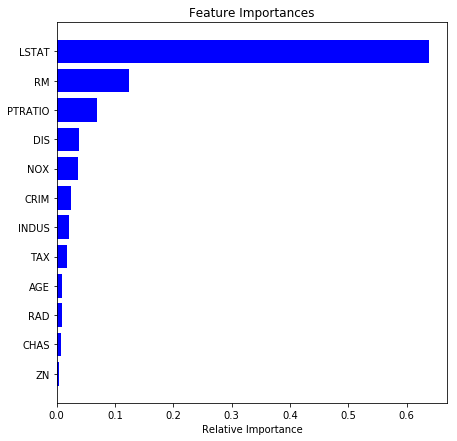

In [20]:
features = X_train.columns
importances = res2.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

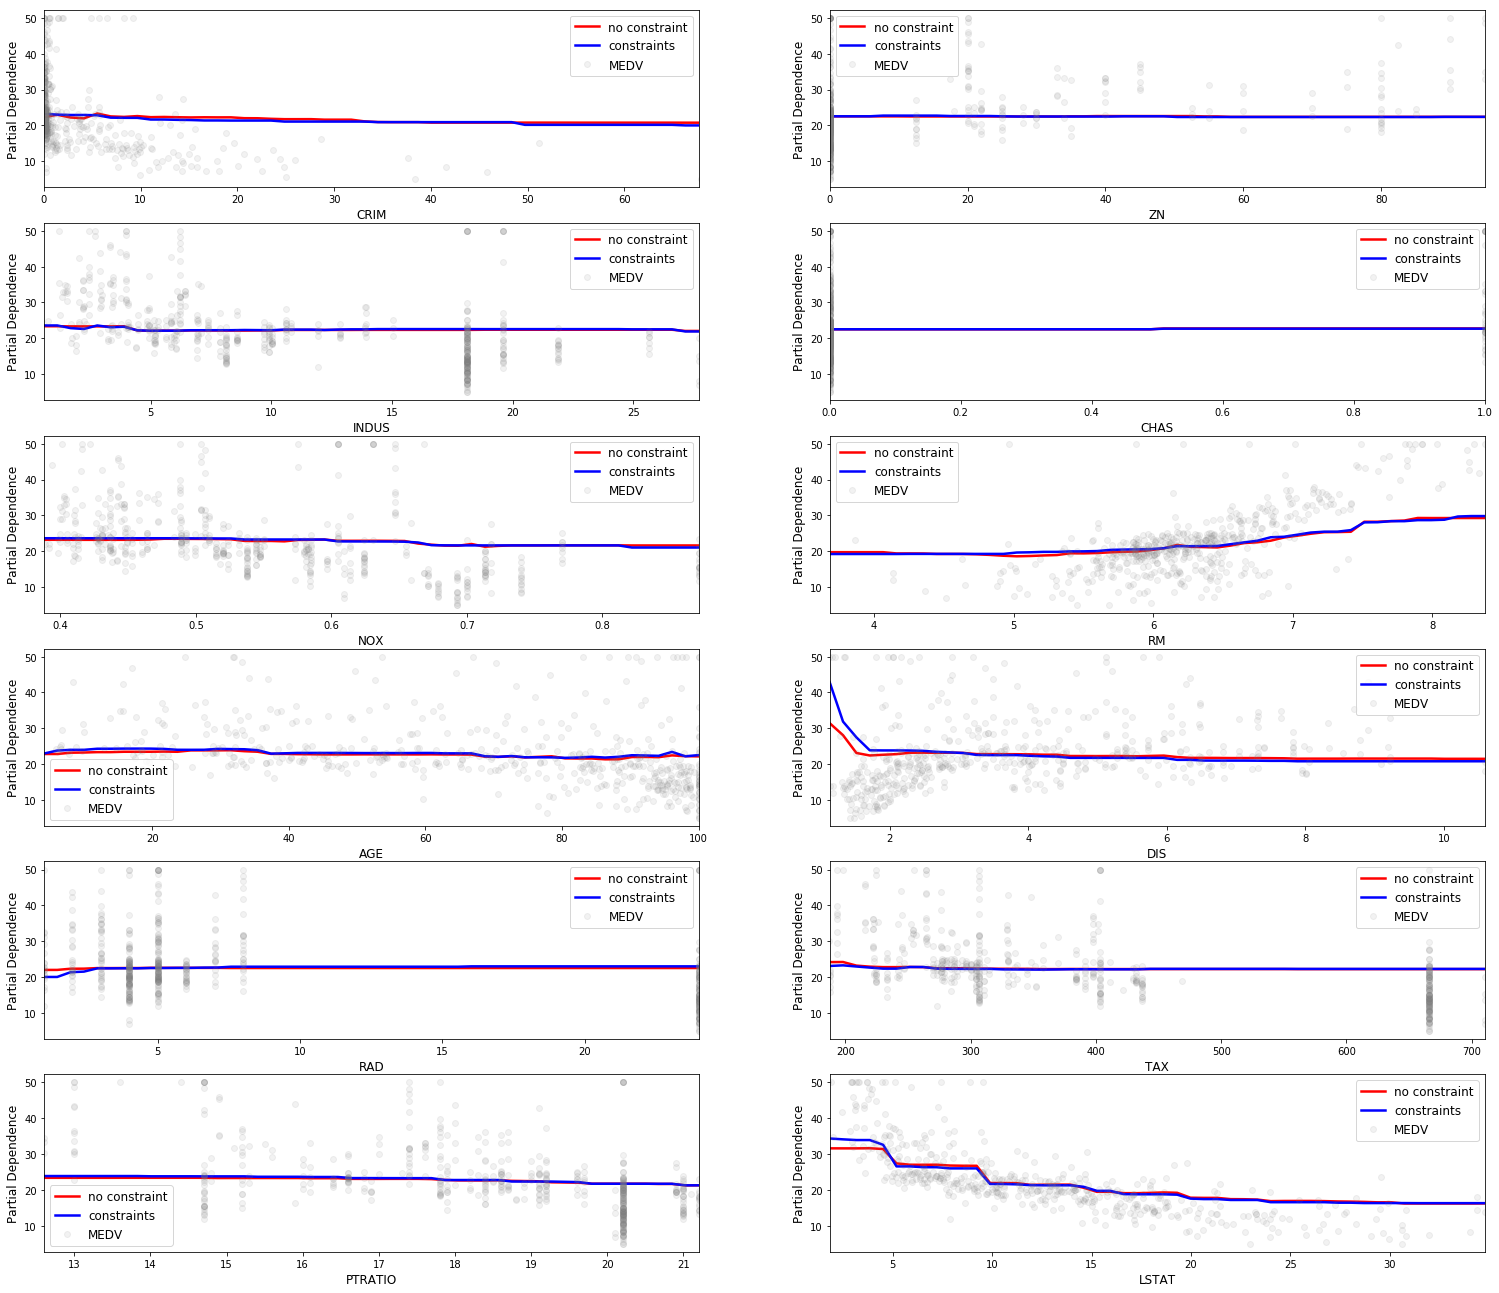

In [23]:
features = X_train.columns
fig, ax = plt.subplots(6, 2)
fig.set_size_inches(23, 23)
plt.subplots_adjust(left = 0.07, right = 0.94, bottom = 0.15, top = 0.9)
for i, f in enumerate(features):
    grid, y_pred = get_partial_dependence(res, f, X_train, y_train)
    grid2, y_pred2 = get_partial_dependence(res2, f, X_train, y_train)
    ax = ax.flatten()
    axis = ax[i]
    axis.plot(grid, y_pred, color = 'red', linewidth = 2.5, label='no constraint')
    axis.plot(grid2, y_pred2, color = 'blue', linewidth = 2.5, label='constraints')
    axis.plot(X.loc[:, f], y, 'o', color = 'grey', alpha = 0.1)
    axis.set_xlim(min(grid), max(grid))
    axis.set_xlabel(f, fontsize = 12)
    axis.set_ylabel('Partial Dependence', fontsize = 12)
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, loc = 'best', fontsize = 12)

In [43]:
df = pd.read_csv("californiaDDSDataV2.csv")
df = df.drop(columns = 'Id')
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,Female,2113,White not Hispanic
1,22 to 50,37,Male,41924,White not Hispanic
2,0 to 5,3,Male,1454,Hispanic
3,18 to 21,19,Female,6400,Hispanic
4,13 to 17,13,Male,4412,White not Hispanic


In [44]:
df.isnull().sum()

Age Cohort      0
Age             0
Gender          0
Expenditures    0
Ethnicity       0
dtype: int64

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
Age Cohort      1000 non-null object
Age             1000 non-null int64
Gender          1000 non-null object
Expenditures    1000 non-null int64
Ethnicity       1000 non-null object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [47]:
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 

df['Ethnicity']= preprocessing.LabelEncoder().fit_transform(df['Ethnicity']) 
df['Gender']= preprocessing.LabelEncoder().fit_transform(df['Gender']) 
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,0,2113,7
1,22 to 50,37,1,41924,7
2,0 to 5,3,1,1454,3
3,18 to 21,19,0,6400,3
4,13 to 17,13,1,4412,7


In [49]:
X, y = df.loc[:,["Age", "Gender", "Ethncity"]], df.loc[:,"Expenditures"]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [55]:
param_grid = {
                'max_depth':range(2,7), 
                'learning_rate': [.07,.09, .1], 
                'random_state': [123],
                'objective':['reg:squarederror'], 
                'n_estimators': [50, 100, 125, 150],
                'reg_gamma': [0, 0.2, 0.5]
}

xgbr = xgb.XGBRegressor()
gr = GridSearchCV(xgbr,param_grid=param_grid,cv=5, verbose=True)
res = gr.fit(X_train,y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:   33.6s finished


In [56]:
print_results(res)

XGB Model best params : {'reg_gamma': 0, 'learning_rate': 0.07, 'random_state': 123, 'objective': 'reg:squarederror', 'max_depth': 2, 'n_estimators': 125}
 Train RMSE: 3451.73063
 Test RMSE: 3454.87725


Text(0.5, 0, 'Relative Importance')

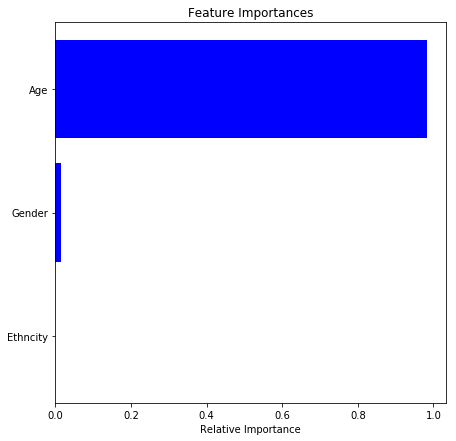

In [57]:
features = X_train.columns
importances = res.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

ValueError: Axis limits cannot be NaN or Inf

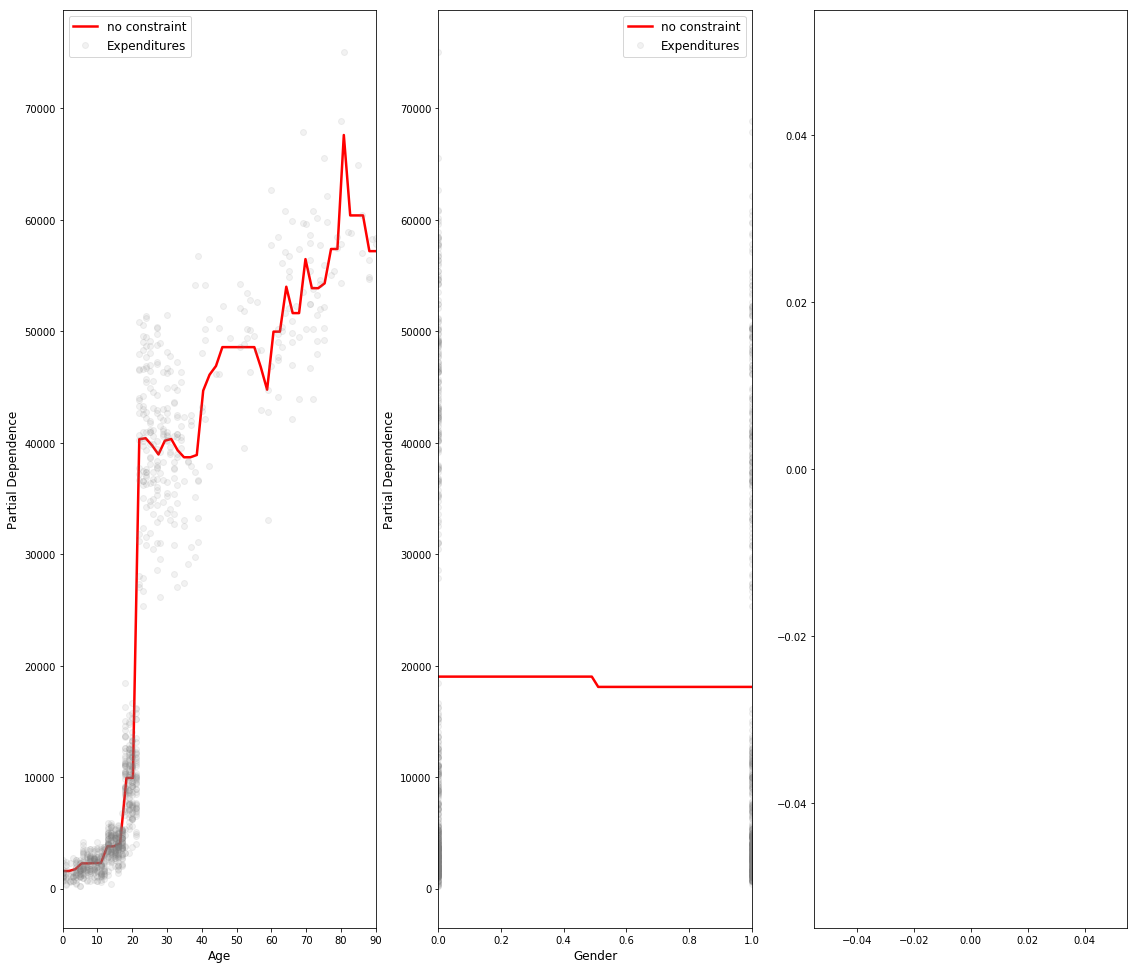

In [54]:
features = X_train.columns
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(5, 5)
plt.subplots_adjust(left = 0.07, right = 0.94, bottom = 0.15, top = 0.9)
for i, f in enumerate(features):
    grid, y_pred = get_partial_dependence(res, f, X_train, y_train)
    ax = ax.flatten()
    axis = ax[i]
    axis.plot(grid, y_pred, color = 'red', linewidth = 2.5, label='no constraint')
    axis.plot(X.loc[:, f], y, 'o', color = 'grey', alpha = 0.1)
    axis.set_xlim(min(grid), max(grid))
    axis.set_xlabel(f, fontsize = 12)
    axis.set_ylabel('Partial Dependence', fontsize = 12)
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, loc = 'best', fontsize = 12)

## II. Usecase 3: The model prediction must not be too sensitive to x3

The two models above give a very high feature importance to the feature LSTAT. For the sake of this usecase we will make the assumption that it should not have such high predictive power. To implement this usecase we will train a model on all features other than LSTAT, use the residuals of model1 to train model2 on all features and then take the combined preidction of these two models

In [24]:
X_train_sub = X_train.drop(columns = 'LSTAT')
X_test_sub = X_test.drop(columns = 'LSTAT')

In [28]:
model1 =  xgb.XGBRegressor(n_estimators = 20)
model1.fit(X_train_sub, y_train)
pred1_train = model1.predict(X_train_sub)
residuals = y_train - pred1_train
model2 = xgb.XGBRegressor()
params = {
                'max_depth':range(2,7), 
                'learning_rate': [.07,.09, .1], 
                'random_state': [123],
                'objective':['reg:squarederror'], 
                'n_estimators': [150, 170, 200, 250],
                'reg_gamma': [0, 0.2, 0.5]
}
gr3 = GridSearchCV(model2,param_grid=params,cv=5, verbose=True)
res3 = gr3.fit(X_train,residuals)
pred2_train = res.predict(X_train)
ypred_train = pred1_train + pred2_train
mse_train = mean_squared_error(y_train, ypred_train)
print("XGB Model best params : {}".format(res3.best_params_))
print(" Train RMSE: %.5f" % (mse_train**(1/2.0)))

[11:11:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 5 folds for each of 180 candidates, totalling 900 fits
XGB Model best params : {'reg_gamma': 0, 'learning_rate': 0.1, 'random_state': 123, 'objective': 'reg:squarederror', 'max_depth': 4, 'n_estimators': 150}
 Train RMSE: 20.79706


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  2.6min finished
